# Pure Premium GLM - Exploratory Data Analysis

Exploratory analysis of the CAS automobile insurance dataset for building frequency and severity GLMs.

## Safe Harbor Disclosure

Educational purposes only. Not for real-world insurance underwriting or pricing decisions.  

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import os
from sklearn.datasets import fetch_openml
import warnings



# Reproducibility: set a global seed used by NumPy (helps when sampling / splitting later)
SEED_VAL = 42
np.random.seed(SEED_VAL)
SKIP_DATA_LOAD = True  # Set to False to redownload the data set from OpenML

# Paths
SOURCE_DATA_PATH = "../data/source"
WORKING_DATA_PATH = "../data/working"
BINNING_DATA_PATH = f"../data/binning"
FIGURE_PATH = "../figures"

for path in [SOURCE_DATA_PATH, WORKING_DATA_PATH, FIGURE_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

# About The Data

The data used in this project is from the [CASDatasets R package](https://dutangc.github.io/CASdatasets/reference/freMTPL.html) and is available on [OpenML](https://www.openml.org/d/41214) and [Kaggle](https://www.kaggle.com/datasets/uciml/freemultipleregion).  It contains data on automobile insurance policies in France, including policyholder demographics, vehicle characteristics, and claim history.  The data is split into two datasets, one for frequency modeling and one for severity modeling.  Each dataset has a unique identifier for each policy (IDpol), which can be used to merge the datasets.

**Table 1: Data Dictionary**

| Dataset   | Column Name | Column Description                          | Data Type | Sample Values                |
|-----------|-------------|---------------------------------------------|-----------|------------------------------|
| Frequency | IDpol       | Unique policy identifier                    | int32     | 1, 3, 5                      |
| Frequency | ClaimNb     | Number of claims on the policy (count)      | int64     | 0, 1, 2                      |
| Frequency | Exposure    | Policy exposure (fraction of year)          | float64   | 0.10000, 0.77000, 0.00274    |
| Frequency | Area        | Territorial code (ordinal: A→F)             | category  | D, B, E                      |
| Frequency | VehPower    | Vehicle power band (ordinal category)       | int64     | 4, 5, 6                      |
| Frequency | VehAge      | Vehicle age in years                        | int64     | 0, 2, 6                      |
| Frequency | DrivAge     | Driver age in years                         | int64     | 29, 41, 55                   |
| Frequency | BonusMalus  | Bonus–malus score (experience-based rating) | int64     | 50, 54, 95                   |
| Frequency | VehBrand    | Vehicle make / brand code (nominal)         | category  | B12, ...                     |
| Frequency | VehGas      | Fuel type (nominal)                         | category  | Regular, Diesel              |
| Frequency | Density     | Population density (numeric)                | int64     | 54, 76, 3317                 |
| Frequency | Region      | Geographic region code                      | category  | R82, R22, R72                |
| Severity  | IDpol       | Unique policy identifier (joins to df_freq) | int32     | 139, 190, 414                |
| Severity  | ClaimAmount | Total claim payout for the policy (sum)     | float64   | 303.00, 1981.84, 10834.00    |

# Data Load — what we'll do and why
1. Load Frequency Data Set
2. Load Severity Data Set
3. Set initial assumptions on data types
4. Join frequency and severity data into one dataset

`Note`: You will need your own `OpenML API key` to download the data.  You can get one by creating a free account on [OpenML](https://www.openml.org/). An example of how to use the API key is shown in the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html).

## Frequency Data Set
Quick scan of the data, showed single quotes in VehGas so I added a transform to remove them.


In [4]:
if not os.path.exists(f"{SOURCE_DATA_PATH}/freq_data.pkl") or not SKIP_DATA_LOAD:
    # Load data required for frequency model
    df_freq = fetch_openml(data_id=41214, as_frame=True).data
    df_freq.to_pickle(f"{SOURCE_DATA_PATH}/freq_data.pkl")
else:
    df_freq = pd.read_pickle(f"{SOURCE_DATA_PATH}/freq_data.pkl")

# Handle minor data issue in VehGas column
df_freq["IDpol"] = df_freq["IDpol"].astype(int)
df_freq["VehGas"] = df_freq["VehGas"].str.strip("'")
df_freq.sample(5, random_state=SEED_VAL)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
261354,2122523,0,0.43,D,7,18,36,95,B1,Regular,1054,R24
448143,3173420,0,0.10,D,7,17,80,95,B2,Regular,598,R25
188618,1188619,0,0.33,E,7,3,36,76,B6,Regular,4172,R82
12952,31400,0,0.56,A,5,4,73,52,B13,Diesel,15,R24
425028,3138755,0,0.27,E,8,0,37,50,B11,Diesel,3021,R53


## Severity Data Set

Loading severity data and grouping by policy ID to consolidate multiple claims per policy.

In [5]:
if not os.path.exists(f"{SOURCE_DATA_PATH}/sev_data.pkl") or not SKIP_DATA_LOAD:
    # Load data required for frequency model
    df_sev = fetch_openml(data_id=41215, as_frame=True).data
    df_sev.to_pickle(f"{SOURCE_DATA_PATH}/sev_data.pkl")
else:
    df_sev = pd.read_pickle(f"{SOURCE_DATA_PATH}/sev_data.pkl")

# Handle minor data issue in VehGas column
df_sev["IDpol"] = df_sev["IDpol"].astype(int)
df_sev = df_sev.groupby("IDpol", as_index=False).sum()
df_sev.sample(5, random_state=SEED_VAL)

,IDpol,ClaimAmount
22806,4175003,602.00
3617,152130,1128.12
20649,4126176,493.68
11213,2086947,6172.00
2140,84582,68.98


## Set column data types

Converting features to appropriate categorical types for modeling.

In [6]:
# Ordinal Categorical Variables
df_freq["Area"] = df_freq["Area"].astype("category")
df_freq["VehPower"] = df_freq["VehPower"].astype("category")

# Nominal Categorical Variables
df_freq["VehGas"] = df_freq["VehGas"].astype("category")
df_freq["VehBrand"] = df_freq["VehBrand"].astype("category")
df_freq["Region"] = df_freq["Region"].astype("category")

## Merge Frequency and Severity Datasets

Left join on policy ID to retain all frequency records, filling null severity values with zero.

In [7]:
# Use left join to ensure that we retain claims frequency for
# policies that do not have claims payouts
df = pd.merge(df_freq, df_sev, on="IDpol", how="left")

# Populate Severity for policies that do not have claims payouts
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

## Basic Data Structure Checks

Reviewing merged dataset structure and checking for missing values.

In [8]:
df.head(5)

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1,1,0.10,D,5,0,55,50,B12,Regular,1217,R82,0.0
1,3,1,0.77,D,5,0,55,50,B12,Regular,1217,R82,0.0
2,5,1,0.75,B,6,2,52,50,B12,Diesel,54,R22,0.0
3,10,1,0.09,B,7,0,46,50,B12,Diesel,76,R72,0.0
4,11,1,0.84,B,7,0,46,50,B12,Diesel,76,R72,0.0


### Data Frame Info

- 678,013 records in the merged dataset
- 13 columns in the merged dataset
- No identified missing values

In [9]:
print(
    f"Number of Policies with Claims Amounts > 0: {df[df['ClaimAmount']>0]['IDpol'].count()}"
)
df.info()

Number of Policies with Claims Amounts > 0: 24944
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   IDpol        678013 non-null  int64   
 1   ClaimNb      678013 non-null  int64   
 2   Exposure     678013 non-null  float64 
 3   Area         678013 non-null  category
 4   VehPower     678013 non-null  category
 5   VehAge       678013 non-null  int64   
 6   DrivAge      678013 non-null  int64   
 7   BonusMalus   678013 non-null  int64   
 8   VehBrand     678013 non-null  category
 9   VehGas       678013 non-null  category
 10  Density      678013 non-null  int64   
 11  Region       678013 non-null  category
 12  ClaimAmount  678013 non-null  float64 
dtypes: category(5), float64(2), int64(6)
memory usage: 44.6 MB


### Descriptive Statistics of Merged Data Set

**Numeric Columns**
- Claim Number has high mean, likely outliers
- Exposure shows max 2.0, but [CASDatasets](https://dutangc.github.io/CASdatasets/reference/freMTPL.html) indicates mostly one year
- VehPower definition not clear, high max, low mean/75th percential, likely need grouping
- Driver Age (domain knowledge) may need capping or binning for explainability
- BonusMalus may need capping.
- Density is very high in some areas/regions.  May need to log(density) to get normal distribution.
- Claim Amount has high max, low mean, possibly indicating need to cap, log, or otherwise handle.
  
**Categorical Columns**
- Values in Area, Region, VehGas and VehBrand are not ordered numerically.
  - Per [CASDatasets](https://dutangc.github.io/CASdatasets/reference/freMTPL.html) documentation:
    - Area is ordered from A (rural) to F (urban center), so we can treat as categorical ordinal
    - Remaining are categorical nominal with no inherent order.
- VehPower is represented as a number, it is categorical ordinal according to [CASDatasets](https://dutangc.github.io/CASdatasets/reference/freMTPL.html) documentation.
- VehBrand and Region have a large number of categories, may need grouping.

In [10]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
IDpol,678013.0,NaN,NaN,NaN,2621856.921071,1641782.752655,1.0,1157951.0,2272152.0,4046274.0,6114330.0
ClaimNb,678013.0,NaN,NaN,NaN,0.053247,0.240117,0.0,0.0,0.0,0.0,16.0
Exposure,678013.0,NaN,NaN,NaN,0.52875,0.364442,0.002732,0.18,0.49,0.99,2.01
Area,678013,6,C,191880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehPower,678013.0,12.0,6.0,148976.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehAge,678013.0,NaN,NaN,NaN,7.044265,5.666232,0.0,2.0,6.0,11.0,100.0
DrivAge,678013.0,NaN,NaN,NaN,45.499122,14.137444,18.0,34.0,44.0,55.0,100.0
BonusMalus,678013.0,NaN,NaN,NaN,59.761502,15.636658,50.0,50.0,50.0,64.0,230.0
VehBrand,678013,11,B12,166024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VehGas,678013,2,Regular,345877,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Zero Paid Claim Check

34,060 claims filed (ClaimNb > 0), 24,944 claims paid (ClaimAmount > 0), 9,116 filed but not paid. All records used for frequency modeling; only paid claims used for severity modeling.

In [11]:
# These masks will allow us to quickly pull all of the relevant subsets of data
masks = {
    "ClaimAmount>0":            df["ClaimAmount"] > 0,
    "ClaimNb>0":                df["ClaimNb"] > 0,
    "ClaimNb>0 & ClaimAmount<=0": (df["ClaimNb"] > 0) & (df["ClaimAmount"] <= 0),
    "ClaimNb<=0 & ClaimAmount>0": (df["ClaimNb"] <= 0) & (df["ClaimAmount"] > 0),
}

# Visualize this to confirm user statements about claim data
summary = pd.DataFrame(
    [{"mask_name": k, "count": int(v.sum()), "share": float(v.mean())} for k, v in masks.items()]
).sort_values("count", ascending=False)

print(summary.to_string(index=False))

                 mask_name  count    share
                 ClaimNb>0  34060 0.050235
             ClaimAmount>0  24944 0.036790
ClaimNb>0 & ClaimAmount<=0   9116 0.013445
ClaimNb<=0 & ClaimAmount>0      0 0.000000


## Snapshot Merged DataSet

Saving merged dataset for traceability.

In [12]:
# Save the for traceability and lineage
df.to_pickle(f"{WORKING_DATA_PATH}/merged_freq_sev.pkl")
df.to_csv(f"{WORKING_DATA_PATH}/merged_freq_sev.csv", index=False)

# Helper Functions

## Standard Plotting Functions

The following functinos will be used to visualize the data for analysis.

- `eda_base_viz_plots`: plots histogram, boxplot, and Empirical CDF for a specified numeric column in the DataFrame.
- `plot_feature_frequency`: plots the frequency distribution of a categorical feature.

In [13]:
# Some basic EDA visualizations for numeric columns
def eda_base_viz_plots(
    df: pd.DataFrame,
    col_name: str = "DrivAge",
    bins: int = 30,
    color: str = "C0",
    edgecolor: str = "black",
    out_file: str = None
) -> None:
    if out_file is None or out_file == "":
        out_file = f"{FIGURE_PATH}/eda/eda_{col_name}_base_viz.png"
    # Remove missing values before plotting
    feats = df[col_name].dropna()
    n_missing = df[col_name].isna().sum()

    # Display basic stats
    # Commented out because dropna was not changing the
    # results of the original df.describe()
    # print(f"Using column: {col_name}; n_observed={len(feats)}, n_missing={n_missing}")
    # display(feats.describe().to_frame(name="value"))

    # Set up the matplotlib figure with 3 subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Plot the Histogram + KDE using seaborn
    # Helps us understand the distribution of values
    # Binning could mask some details, so we add a KDE overlay
    sns.histplot(feats, bins=bins, kde=True, color=color, edgecolor=edgecolor, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel("Number of policies")
    ax1.set_title(f"Histogram + KDE of {col_name}")

    # Plot the Boxplot using seaborn
    # Allows us to see outliers in the distribution
    sns.boxplot(x=feats, color=color, ax=ax2)
    ax2.set_xlabel(col_name)
    ax2.set_title(f"Boxplot of {col_name} (high-level outlier view)")

    # Plot the Empirical CDF using seaborn
    # Allows us to understand cumulative trends
    sns.ecdfplot(feats, color=color, ax=ax3)
    ax3.set_xlabel(col_name)
    ax3.set_ylabel("ECDF")
    ax3.set_title(f"ECDF of {col_name}")

    # Plot all 3 subplots together
    plt.grid(alpha=0.2)
    fig.savefig(out_file, dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()


## Plot features with frequency
## Allows us to see important information about how frequency varies by feature
## and how counts and frequency relate to each other
def plot_feature_frequency(
    df_freq_by_feature: pd.DataFrame,
    feature: str,
    figsize=(10, 5),
    title: str = None,
    xtick_step: int | None = None,
    out_file: str = None
) -> None:
    if not os.path.exists(f"{FIGURE_PATH}/eda"):
        os.makedirs(f"{FIGURE_PATH}/eda")
    if out_file is None or out_file == "":
        out_file = f"{FIGURE_PATH}/eda/eda_{feature}_freq_viz.png"
    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    dff = df_freq_by_feature[df_freq_by_feature["feature_name"] == feature].copy()

    # Try to sort by numeric feature_value when possible, otherwise keep categorical order
    numeric_mode = False
    try:
        dff["feature_value_num"] = pd.to_numeric(dff["feature_value"])
        dff = dff.sort_values("feature_value_num")
        x = dff["feature_value_num"].values
        xlabels = dff["feature_value"].astype(str).values
    except Exception:
        dff = dff.sort_values("feature_value", key=lambda s: s.astype(str))
        x = np.arange(len(dff))
        xlabels = dff["feature_value"].astype(str).values

    # Need count and frequency values to plot
    counts = dff["feature_count"].astype(float).values
    freq = dff["frequency_value"].astype(float).values

    # scale frequency to the count axis for plotting on the same axes
    if freq.max() > 0:
        scale_factor = counts.max() / freq.max()
    else:
        scale_factor = 0.0

    scale_factor = counts.max() / freq.max() if freq.max() > 0 else 0.0
    freq_scaled = freq * scale_factor

    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.bar(x, counts, color="C0", alpha=0.6, label="Count")
    ax1.plot(
        x,
        freq_scaled,
        color="C3",
        marker="o",
        linestyle="-",
        label="Frequency (scaled)",
    )
    ax1.set_xlabel(feature)
    ax1.set_ylabel("Count")
    ax1.set_xticks(x)
    ax1.set_xticklabels(xlabels, rotation=45, ha="right")

    # Configure x-ticks according to xtick_step when provided
    if xtick_step is not None:
        if numeric_mode:
            # Use a numeric range for ticks (works well for ages)
            start = int(np.nanmin(dff["feature_value_num"]))
            end = int(np.nanmax(dff["feature_value_num"]))
            xticks_vals = np.arange(start, end + 1, xtick_step)
            ax1.set_xticks(xticks_vals)
            ax1.set_xticklabels(
                [str(int(v)) for v in xticks_vals], rotation=45, ha="right"
            )
        else:
            # For categorical, show every nth label
            idx = np.arange(0, len(x), xtick_step)
            ax1.set_xticks(x[idx])
            ax1.set_xticklabels(xlabels[idx], rotation=45, ha="right")
    else:
        ax1.set_xticks(x)
        ax1.set_xticklabels(xlabels, rotation=45, ha="right")

    # secondary y-axis showing the true frequency scale
    if scale_factor > 0:
        forward = lambda left: left / scale_factor  # left-axis -> frequency
        inverse = lambda right: right * scale_factor  # frequency -> left-axis
    else:
        forward = inverse = lambda v: v
    ax2 = ax1.secondary_yaxis("right", functions=(forward, inverse))
    ax2.set_ylabel("Frequency")

    ax1.set_title(title or f"Observed Frequency and Count by {feature}")
    ax1.legend(loc="upper left")
    fig.savefig(out_file, dpi=300, bbox_inches="tight")
    plt.tight_layout()
    plt.show()




## Frequency Calculations

**Exposure Frequency Calculation Function**

We will calculate frequency for model features of interest.  This will allow us to see how frequency and distributions vary by feature.  Frequency is calculated as the sum of the number of claims divided by the sum of exposure at each level.

The function `calculate_feature_frequency` computes the frequency of claims for a specified feature in the DataFrame. It groups the data by the feature, sums the number of claims and exposure, and calculates the frequency as the ratio of total claims to total exposure.

In [14]:
# Function to calculate frequency by feature
# Frequency is calculated as the sum of the number of claims divided by the sum of exposure
# All frequencies will be output to a single DataFrame for later use.
def calculate_feature_frequency(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    freq_df = (
        df.groupby(feature, observed=False)
        .agg(
            total_count=pd.NamedAgg(column="IDpol", aggfunc="count"),
            total_claims=pd.NamedAgg(column="ClaimNb", aggfunc="sum"),
            total_exposure=pd.NamedAgg(column="Exposure", aggfunc="sum"),
        )
        .reset_index()
    )
    freq_df["feature_name"] = feature
    freq_df["feature_value"] = freq_df[feature]
    freq_df["feature_count"] = freq_df["total_count"]
    freq_df["frequency_value"] = freq_df["total_claims"] / freq_df["total_exposure"]
    # saved after last call as a consolidated dataset.  Do not need to save here.
    return freq_df[
        ["feature_name", "feature_value", "feature_count", "frequency_value"]
    ]

## Severity Plotting Functions

- `eda_base_viz_plots`: Before we look at log scale, we will run a base visualization on the severity data.  This will allow us to see the untransformed distribution, boxplots, and CDF.
- `eda_log_scale_plots`: Used to create variants of log scale distribution plots for a specified numeric column in the DataFrame.  In this case, we will use it to visualize the severity distribution.

In [15]:
# For some features, we want to see the distribution on a log scale
# This is especially useful for features like Density and Severity
# which have a wide range of values and are highly skewed
def eda_log_scale_plots(df_severity: pd.DataFrame, col_name: str="Severity") -> None:
    # Don't plot if the column does not exist
    if col_name not in df_severity.columns:
        raise ValueError(f"Column '{col_name}' not found in DataFrame.")
    
    # We want to see all three plots side by side for comparison
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))

    # Keeps the data in place and scales the x-axis to log scale
    sns.histplot(df_severity[col_name], bins=100, kde=True, ax=ax1)
    ax1.set_xscale("log")
    ax1.set_title(f"Histogram of {col_name} (log scale)")
    ax1.set_xlabel(f"{col_name} (log scale)")

    # Transforms the data using log(x + 1) to handle zero values
    # and bins in equal log widths
    sns.histplot(np.log1p(df_severity[col_name]), bins=100, kde=True, ax=ax2)
    ax2.set_title(f"Histogram of log({col_name} + 1)")
    ax2.set_xlabel(f"log({col_name} + 1)")

    # Leave scale alone but clip extream outliers (> 99.5 percentile)
    cap = df_severity[col_name].quantile(0.995)
    sns.histplot(df_severity.loc[df_severity[col_name] <= cap, col_name], bins=100, kde=True, ax=ax3)
    ax3.set_title(f"Histogram of {col_name} (capped at 99.5%)")
    ax3.set_xlabel(col_name)

    # Adjust layout and show the figure
    plt.tight_layout()
    fig.savefig(f"{FIGURE_PATH}/eda/eda_{col_name}_log_scale_viz.png", dpi=300, bbox_inches="tight")
    print(f"Saved figure to {FIGURE_PATH}/eda/eda_{col_name}_log_scale_viz.png")
    plt.show()

# Calculate Frequency by Feature

Here we will define which features we want to calculate frequency for, and then loop through each feature to calculate frequency and store the results in a single DataFrame for easy analysis and plotting.  We do this by calling the `calculate_feature_frequency` function defined above.

In [16]:
# Lookt at all columns excpet our targets
# Frequency Target = ClaimNb
# Severity Target = ClaimAmount
freq_columns = [
    "DrivAge",
    "VehAge",
    "VehPower",
    "VehGas",
    "VehBrand",
    "Area",
    "Region",
    "BonusMalus",
    "Density"
]
# We are going to store all data returned from frequency calculations
# in the same DataFrame for easy analysis and plotting
df_freq_by_feature = pd.DataFrame()

# We will calculate frequency for model features of interest in one loop
for feature in freq_columns:
    df_feat_freq = calculate_feature_frequency(df, feature)
    df_freq_by_feature = pd.concat(
        [df_freq_by_feature, df_feat_freq], ignore_index=True
    )

# Save the frequency by feature data for auditability and lineage
df_freq_by_feature.to_csv(f"{WORKING_DATA_PATH}/frequency_by_feature.csv", index=False)

# Preview the data to make sure it looks correct
df_freq_by_feature.sample(10, random_state=SEED_VAL)

,feature_name,feature_value,feature_count,frequency_value
582,Density,254,186,0.126335
901,Density,591,74,0.000000
907,Density,597,9,0.000000
1754,Density,3834,195,0.145031
1464,Density,1693,78,0.099231
1235,Density,1101,342,0.061211
1599,Density,2411,336,0.079498
855,Density,536,19,0.000000
1231,Density,1085,112,0.120128
926,Density,623,68,0.072389


# Visualizing Data

## Frequency Analysis

Here we will create visualizations of frequency by feature to help identify trends and patterns.  We will create plots that show both frequency of claims and distributions of policies by feature level.  This will help us identify features that may be predictive of claim frequency.

For these charts, the frequency is calculated as the sum of claims divided by the sum of exposure for each level of the feature.  The distribution is calculated as the count of policies at each level divided by the total number of policies. This information was collected in the `df_freq_by_feature` DataFrame created above.

### Driver Age

The driver age features shows a U-shaped frequency curge where young drivers (<25) and older drivers (>75) have higher claims frequencies.  There are fe date points for ages 85 and over.  This is a standard age-risk pattern in auto insurance with strong non-linearity.  Outlier ages introduce noise due to low explsoure.  We will cap or bin the driver age feature for modeling.  This feature appears to be highly predictive of claim frequency.

**Additional Considerations**

Here we could consider using a spline to smooth non-linearity in the driver age feature.

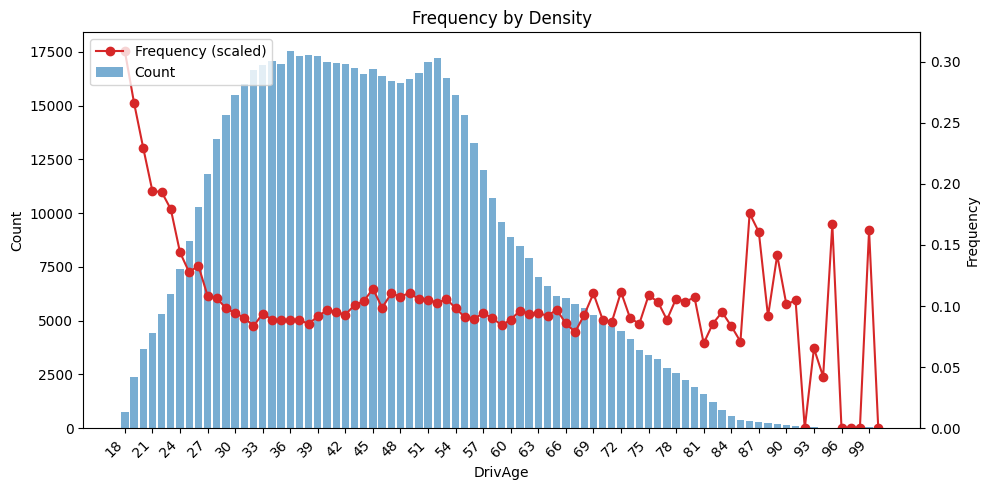

In [17]:
    # Driver Age
    plot_feature_frequency(
        df_freq_by_feature,
        feature="DrivAge",
        title=f"Frequency by {feature}",
        xtick_step=3,
    )

### Vehicle Age

Vehicle age shows the highest frequency for newer vehicles between 0 and 2 years old.  Following this, there is a fairly flat frequency until year 20.  There is a lot of noise after year 25 and much fewer exposures.  This indicates that that owners of newer vehicles may be more likely to file claims.  The sparse tail will likely cause volatility in the model and should be capped or binned accordingly.

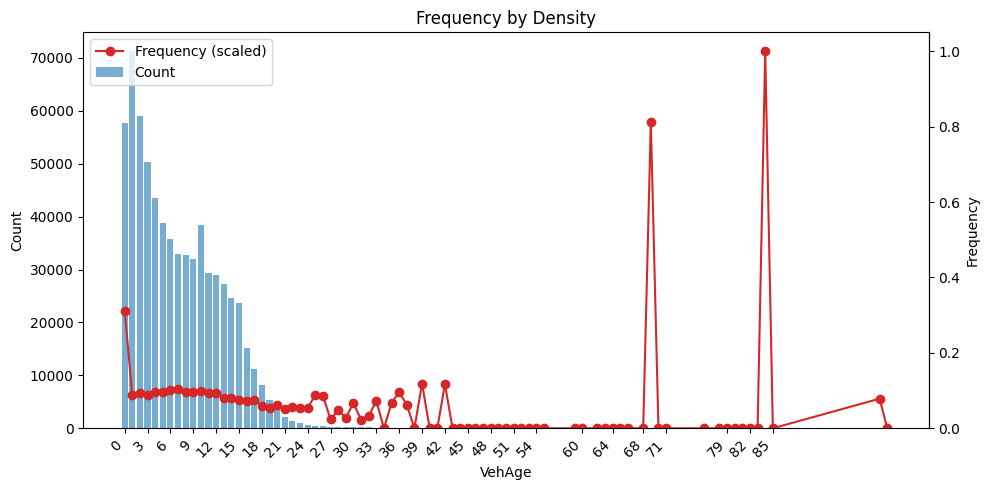

In [18]:
# Vehicle Age
plot_feature_frequency(
    df_freq_by_feature,
    feature="VehAge",
    title=f"Frequency by {feature}",
    xtick_step=3,
)

### Vehicle Brand

Vehcile brand sports 11 brands in it's levels.  Frequency varies, but there is no clear pattern.  Some brands have higher exposure and average frequency while others with lower exposure have higher volatility.  This seems like mostly categorical noise but may be a by product of the vehicle type-mix in our book of business.  We will retain the feature, but may consider binning to reduce potential instability in the model.

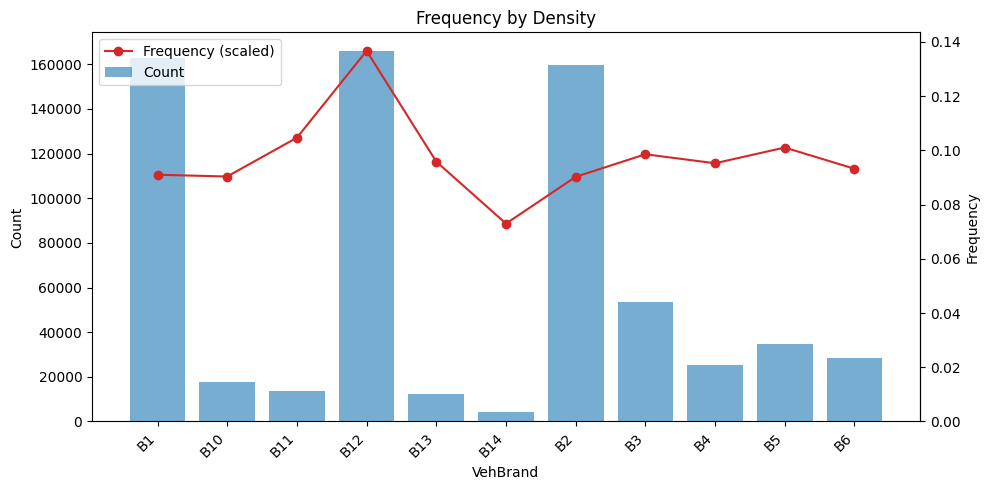

In [19]:
# Vehicle Brand
plot_feature_frequency(
    df_freq_by_feature,
    feature="VehBrand",
    title=f"Frequency by {feature}",
    xtick_step=1,
)

### Vehicle Gas

Vehicle Gas has two levels, Regular and Diesel.  There is relatively identical frequency and counts.  There is a high likelihood that this feature will have coefficients near zero in the model and may be dropped.

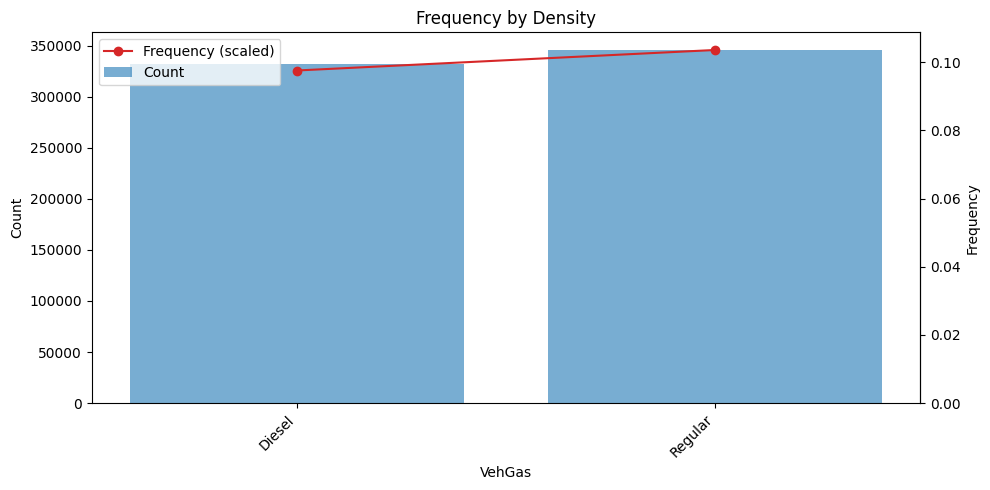

In [20]:
# Vehicle Gas
plot_feature_frequency(
    df_freq_by_feature,
    feature="VehGas",
    title=f"Frequency by {feature}",
    xtick_step=1,
)

### Vehicle Power

Vehicle power shows roughtly stable frequency across levels within the 0.08 to 0.12 range.  Counts appear concentrated under the 7 range.  Above this, the higher power levels have sparse counts and more volatility.  We will likely cap or bin this feature to reduce noise in the model.

**Additional Considerations**

This feature may be considered in future interaction analysis to determine if it has predictive power when combined with other features (e.g.,`DrivAge * VehPower`).

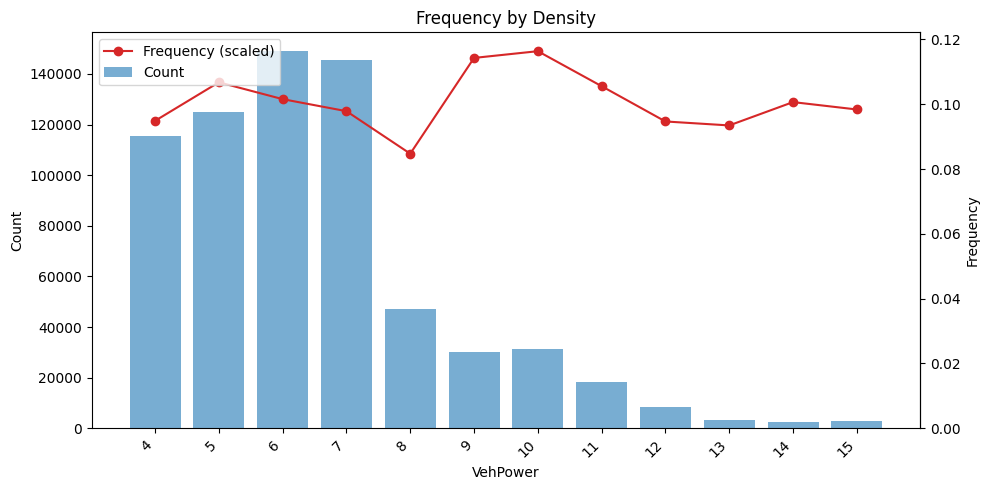

In [21]:
# Vehicle Power
plot_feature_frequency(
    df_freq_by_feature,
    feature="VehPower",
    title=f"Frequency by {feature}",
    xtick_step=1,
)

### Area

Area values range between A (rural) and F (urban center).  There is a clear trend of increasing frequency as we move from rural to urban areas indicating a monotonic trend.  This feature may have some collinearity with density and region, so we will need to monitor this in the modeling phase.  We will keep this as a nominal categorical variable in the model or convert to ordinal to retain the monotonic relationship.

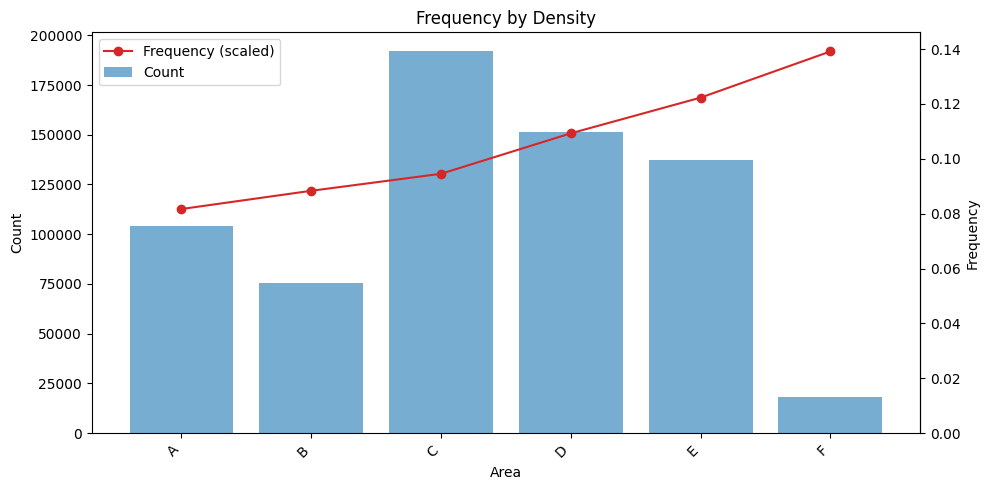

In [22]:
# Area
plot_feature_frequency(
    df_freq_by_feature,
    feature="Area",
    title=f"Frequency by {feature}",
    xtick_step=1,
)

### Region

Region contains 22 geographic region codes.  There is uneven distribution of counts across regions, with some regions having very low counts.  Frequency varies mildly across regions, but there is no clear pattern.  This feature may have some collinearity with area and density, so we will need to monitor this in the modeling phase.  Due to the sparse nature of the data we will consider binning or regularization to reduce noise in the model.

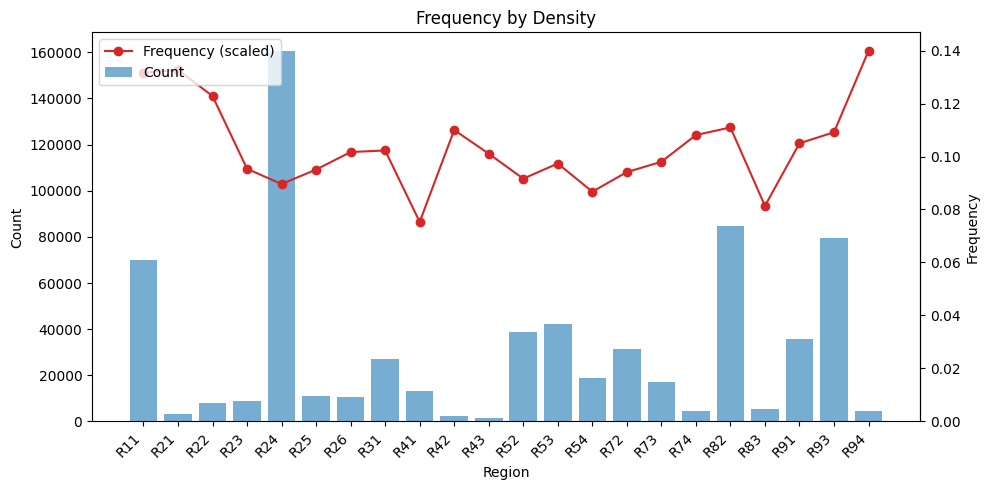

In [23]:
# Region
plot_feature_frequency(
    df_freq_by_feature,
    feature="Region",
    title=f"Frequency by {feature}",
    xtick_step=1,
)

### Density

So, this graph is a bit of an eye sore due to its scale.  Density ranges from 0 to over 20,000 people per square kilometer with the vast majority of observates under 1600.  The frequency appears to be relatively stable across density levels, with a slight increase in frequency as density increases.  There is a high concentration of counts in the lower density levels, with a long tail of sparse counts at higher density levels.  We will consider log transforming or binning into Urban Levels (e.g., Rural, Suburban, Urban) to reduce noise in the model.

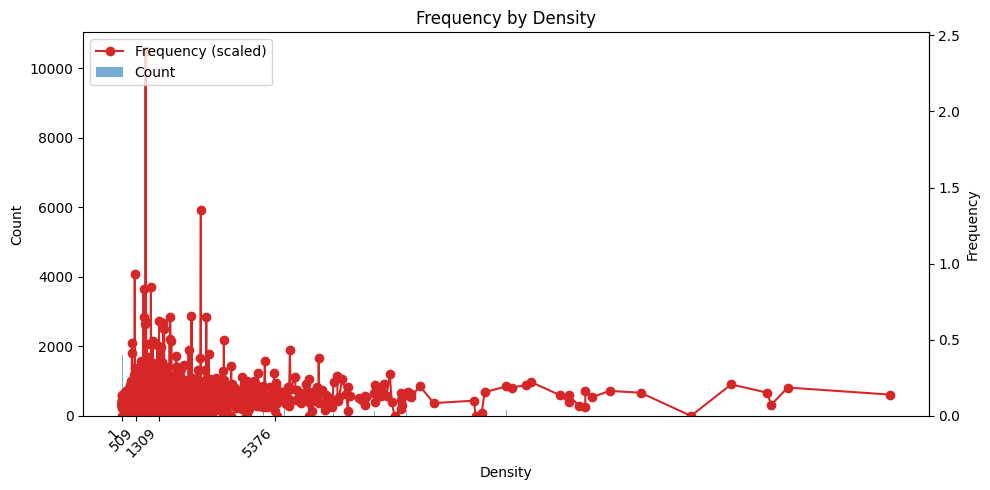

In [24]:
# Density
plot_feature_frequency(
    df_freq_by_feature,
    feature="Density",
    title=f"Frequency by {feature}",
    xtick_step=500,
)

### Bonus Malus

Bonus Malus is an experience-based rating system used in insurance to adjust premiums based on the policyholder's claim history.  In this dataset, the BonusMalus feature ranges from 50 to 130, with higher values indicating a better claim history and lower risk.  Frequency is fairly flat below 100, then rises sharply above 100.  There are sparse counts at the high end of the scale.  There is a non-linear increasing risk patter which is a strong behavioral signal.  We will likely keep this as a numeric feature in the model, but may consider capping or binning into tiers to reduce noise from sparse counts at the high end of the scale.

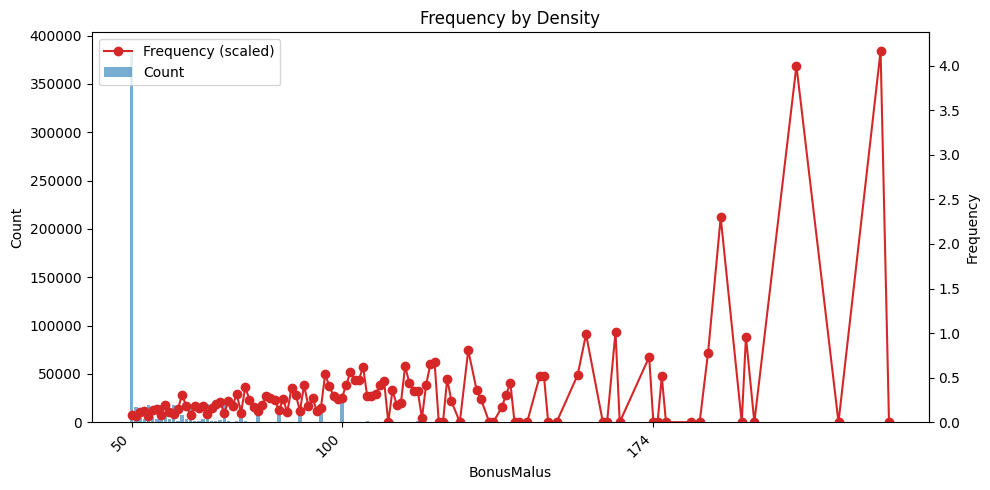

In [25]:
# BonusMalus
plot_feature_frequency(
    df_freq_by_feature,
    feature="BonusMalus",
    title=f"Frequency by {feature}",
    xtick_step=50,
)

### Frequency Observations

These visualizations provided insights into the volume of policies and frequency of claims at a feature level.  Many of the features show trends that indicate they will be useful predictors of claim frequency, but may need to be binned or capped to provide more explainable results. Features that appear to be strong predictors of frequency include Driver Age, Vehicle Age, Area, and BonusMalus.  Features that may be less predictive include Vehicle Gas and Region.  However, I will keep all features for modeling and evaluate their importance in the model results.

## Severity Analysis

Here we will look at severity distribution, boxplots, and CDF.  We will also look at log scale plots as indicators on which modeling approach to take (e.g., gamma with log link, inverse Gaussian, etc.).

### Untransformed Severity

Over 90% of policies have severity < 1,000 euros.  There are few outliers that have claims as high as 4,000,000 euros.  KDE and ECDF plots show heavy-tailed, right-skewed distributions.  This indicates that for severity modeling we will likely need to use a Gamma distribution with a log link function.  We will need to handle outliers in the model by capping.  For severity modeling, we will only use records where ClaimAmount > 0.

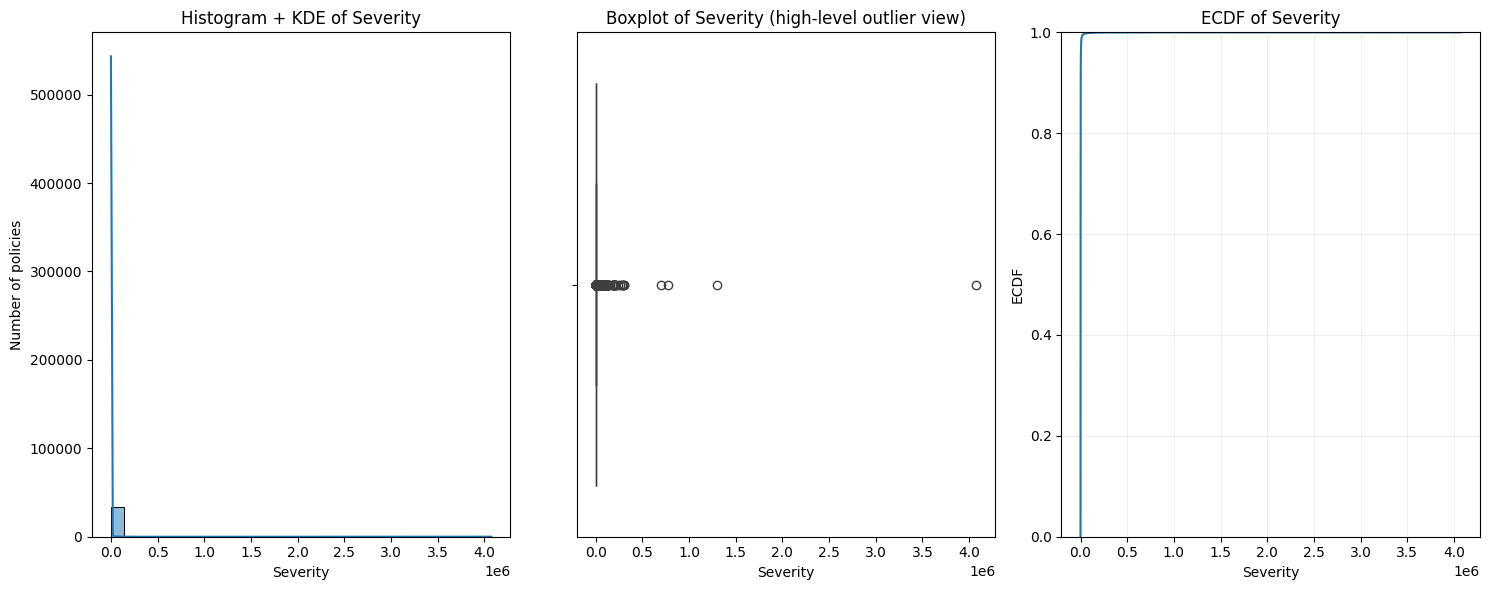

In [26]:
# Severity is the Average Claim Amount per Claim
# We will visualize the severity distribution to see if it needs transformation
df["Severity"] = df["ClaimAmount"] / df["ClaimNb"]

# Not strictly necessary, but these graphs were used for other numeric features
# which hve been removed for focus
base_viz_features = ["Severity"]

for feature in base_viz_features:
    eda_base_viz_plots(df, col_name=feature)

### Log Transformed Severity

Log(1+severity) shows more normal distribution with mode around €400-€3,000. 99.5th percentile cap smooths to unimodal around €2,000.

Saved figure to ../figures/eda/eda_Severity_log_scale_viz.png


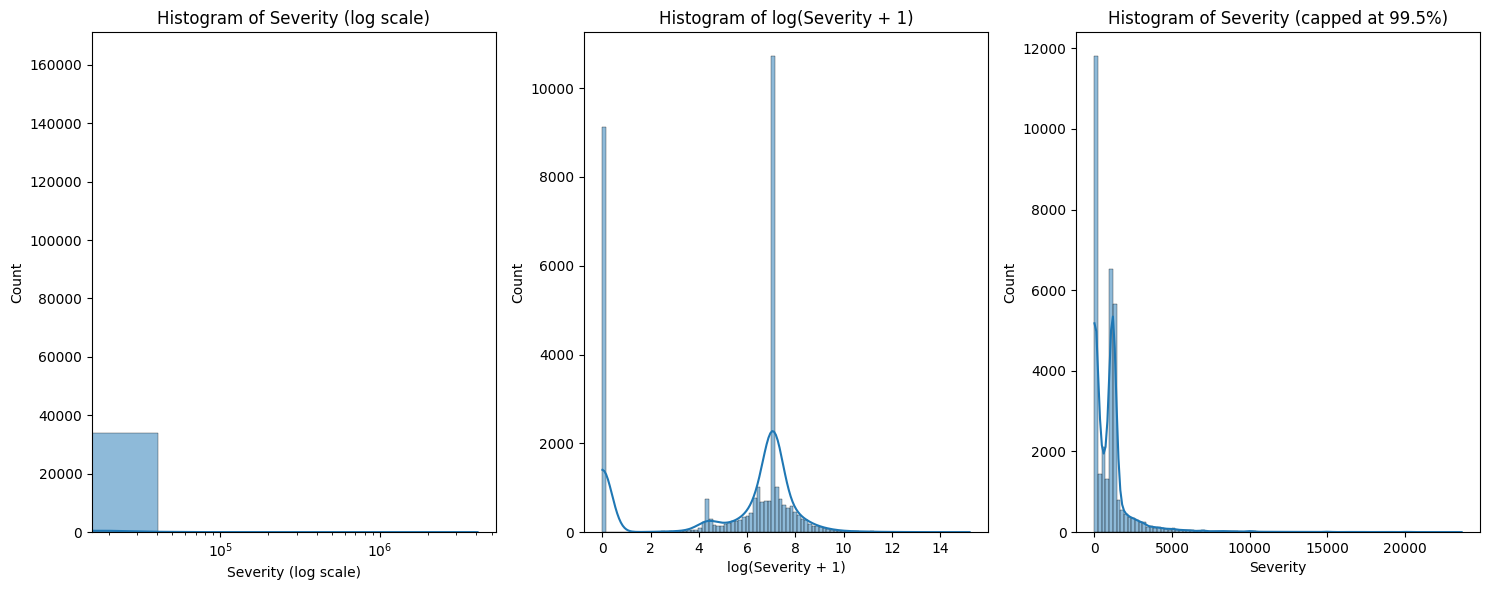

In [27]:
# Same data on a log scale
eda_log_scale_plots(df, col_name="Severity")

### Severity Observations

Gamma distribution with log link appropriate. Will evaluate various capping strategies to reduce outlier impact.

## Correlation Analysis

The correlation matrix below shows there are no highly correlated features (r > 0.8) in the dataset.  Here are some observations we can make from the correlation matrix:
- **DrivAge and BonusMalus**: These features show moderately strong negative correlation.  Young drivers tend to have higher BonusMalus Scores.
- **Exposure and BonusMalus**: There is a slight negative correlation indicating that policies with longer exposure terms tend to have lower BonusMalus scores.
- **DrivAge and Exposure**:  There is a slight positive correlation indicating that older drivers tend to have longer exposure terms.
- **VehAge and Exposure**: There is a slight positive correlation indicating newer vehciles tend to have shorter exposure terms.

While these correlations provide useful insights, they are relatively weak (coefficients < 0.3).  This suggests that while there are some relationships between features, they are not strong predictors on their own.  More advanced modeling techniques may be needed to capture complex interactions and non-linear effects in the data.


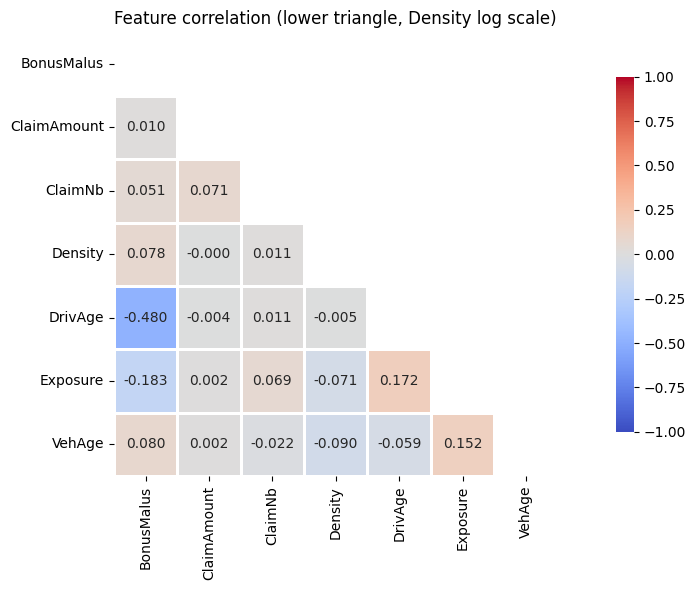


Highly correlated feature pairs (abs corr >= 0.8):
No highly correlated feature pairs found.


In [28]:
# Get numeric columns, excluding IDpol and Severity if present
# Remove Severity to avoid perfect correlation with ClaimAmount and ClaimNb
# which were used to calculate it
num_cols = df.select_dtypes(include=[np.number]).columns.difference(["IDpol","Severity"]).tolist()

if not num_cols:
    print("No numeric feature columns found for correlation plot.")
else:
    corr = df[num_cols].corr()
    
    # Plot correlation heatmap
    mask = np.triu(np.ones_like(corr, dtype=bool))
    fig, ax = plt.subplots(figsize=(12, max(6, len(num_cols) * 0.35)))
    sns.heatmap(corr, mask=mask, annot=True, fmt=".3f", cmap="coolwarm", 
                center=0, vmin=-1, vmax=1, square=True, linewidths=1,
                cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title("Feature correlation (lower triangle, Density log scale)")
    plt.tight_layout()
    fig.savefig(f"{FIGURE_PATH}/eda/eda_feature_correlation_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Find highly correlated pairs
    threshold = 0.8
    high_corr = (corr.abs()
                 .where(~np.eye(corr.shape[0], dtype=bool))
                 .stack()
                 .rename("abs_corr")
                 .reset_index()
                 .query(f"abs_corr >= {threshold}")
                 .sort_values("abs_corr", ascending=False))
    
    print(f"\nHighly correlated feature pairs (abs corr >= {threshold}):")
    if high_corr.empty:
        print("No highly correlated feature pairs found.")
    else:
        for _, row in high_corr.iterrows():
            print(f"{row['level_0']} <-> {row['level_1']}: {row['abs_corr']:.2f}")

# Feature Engineering

I will be creating new features in the data frame rather than replacing existing features.  This will allow us to compare models with and without the new features during modeling.  This also preserves the original data for reference and auditability.

## Cap Features

- **ClaimNb** at `4`: After reviewing the distribution and boxplot, I decided to cap `ClaimNb` at 4.  This is because the vast majority of policies have 0 claims.  There are only 7 policies that have 4 claims.  Bringing those claims in to be included in the bucket with 4 claims will reduce the impact of the few extreme outliers with very high claim counts that could skew the model.  We are only loosing a small amount of information by capping at 4, but we are gaining model stability.
- **BonusMalus** at `150`:  The BonusMalus score has a long tail with some very high values.  I decided to cap it at 150, which is within the 95th percentile.  This will help reduce the impact of extreme outliers on the model.  However, if we had additional driver characteristics (aside from age), we would have wanted to evaluate if those characteristics correlated with very high BonusMalus scores.
- **VehPower** at `8`:  There are very few vehicles with power greater than 8.  Capping at 8 will help reduce the impact of these outliers on the model.
- **DrivAge** at `80`:  I capped driver age at 80 to reduce impact on model.  However, I will also bin drivers into Age Groups.  Grouping drivers into age groups is a common practices in insurance modeling and is preferred by regulators.  It is difficult to explain why a 45 year old driver is riskier than a 44 year old driver, but it is easier to explain why a driver in the 40-49 age group is riskier than a driver in the 30-39 age group.
- **VehAge** at `22`:  I capped vehicles at age 25 as the vast majority of vehicles are less than 25 years old.  As we saw in the distibution and frequency analysis, vehicles older than 25 years have a large amount of variability in claim frequency.  Capping at 25 will help reduce their impact in the model.
- **Exposure** at `1` (assuming one year collection period):  I capped exposure at 1, assuming the data was collected over a one year period.  While the study did indicate that `most` policies were for one year, there were some policies with exposure greater than 1.  Capping at 1 servers two purposes: 1) it aligns with the assumption of a one year collection period, and 2) it reduces the impact of policies with very high exposure on the model.


In [29]:
# Allow us to easily adjust which features to cap and at what values
# to use when experimenting with different capping strategies
caps = {
    "ClaimNb": 4,
    "BonusMalus": 150,
    "DrivAge": 80,
    "VehAge": 22,
    "Exposure": 1,
    "ClaimAmount": 100000,
}

# We're adding new columns rather than overwriting the original features
# allows for greater flexibility in modeling experiments so we do not
# have to come back and retransform the our data.
for col, cap in caps.items():
    df[col + "_capped"] = df[col].clip(upper=cap)
    print(f"Capped {col} at {cap}")

# For ClaimAmount, also creating a quantile capped version
# This will allow us to evaluate the impact of different capping strategies
# on model performance without having to reprocess the original data

claim_amt_quantile_cap = df["ClaimAmount"].quantile(0.9999)
df["ClaimAmount_quantile_capped"] = df["ClaimAmount"].clip(upper=claim_amt_quantile_cap)
print(f"Capped ClaimAmount at quantile 0.9999 value of {claim_amt_quantile_cap}")

# Density is highly skewed, so we will use a log transformation
# to scale it better for modeling
df["Density_log"] = np.log1p(df["Density"])
print("Applied log(1+x) transformation to Density")

Capped ClaimNb at 4
Capped BonusMalus at 150
Capped DrivAge at 80
Capped VehAge at 22
Capped Exposure at 1
Capped ClaimAmount at 100000
Capped ClaimAmount at quantile 0.9999 value of 65428.71152787137
Applied log(1+x) transformation to Density


### Check for duplicates

Verifying no duplicate records introduced by capping.

In [30]:
# Ensure that no duplicates exist in the dataset, if so we need to explain them
df_capped_unique = df.drop_duplicates(ignore_index=True)
if df.shape[0] != df_capped_unique.shape[0]:
    raise ValueError(
        f"Dropped {df.shape[0] - df_capped_unique.shape[0]} duplicate rows - please investigate"
    )
else:
    print("No duplicate rows found after capping.")

No duplicate rows found after capping.


## Create Binned Features

The following binning strategies were chosen based on a combination of domain knowledge and reference material for projects working with the same data (see project references).  I created these bins to compare intuitive, domain-knowledge driven bins with more statistically driven approaches (e.g. using OptBinning).  Another thing to note is that these bins are not configured for a specific target (frequency or severity).  They are intended to be general purpose bins that can be used for either target.  Since they are not optimized for a specific target, they may not be optimal for either target.  This is an area for further exploration and analysis.

- **DrivAge -> DrivAge_ManualBin**:  We will create age groups for drivers.  This is a common practice in insurance modeling and is preferred by regulators.  Earlier, we decided to cap `DrivAge` at 80 to reduce the impact of extreme outliers.  However, I am also going to bin drivers up to age 22 together.  Drivers 23-25 will Group.  After that, we will use 5 year increments up to age 75.  All drivers older than 75 will be grouped together.  This approach balances the need for explainability with the need to capture risk differences among age groups.
- **VehAge -> VehAge_ManualBin**: I am grouping vehicle ages into bins arbitrarily as an experiment.  I chose to group vehicles 0-3 years old together, 4-7 years old together, 8-15 years, and 16+.  The goal of this experiment is to see if varying bin sizes can capture risk differences better than uniform bin sizes.  This is an area for further exploration and analysis.
- **BonusMalus -> BonusMalus_ManualBin**: Rather than dropping or normalizing `BonusMalus` earlier, I capped the feature at 175.  Now, I will create tiers for BonusMalus.  I will create 4 tiers: `Excellent` (49-75), `Good` (76-100), `Average` (101-125), and `Poor` (126+).  This approach will allow us to experiment with whether individual BonusMalus scores or tiers better capture risk differences.
- **Density -> UrbanLevel_ManualBin**:  Here we group density into 4 levels: `Rural` (0-500), `Suburban` (500-2,000), `Urban` (2,001-10,000), and `Metropolitan` (10,001+).  Since population density is numeric, this grouping will allow us to see if there is commonality in Urban Level risk that wouldn't be identified by the individual integer ranges populated in the dataset.

In [31]:
# Comments indicate why

# Driver age groups binned in 5 year increments from age 25
# through 75.  This simulates an insurer's business decision
# based on domain knowledge and regulatory explainability.
# These bins may not be optimal for this dataset.
df["DrivAge_ManualBin"] = pd.cut(
    df["DrivAge"],
    bins=[17, 22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100],
    labels=[
        "18-22",
        "23-25",
        "26-30",
        "31-35",
        "36-40",
        "41-45",
        "46-50",
        "51-55",
        "56-60",
        "61-65",
        "66-70",
        "71-75",
        "76+",
    ],
)

# After looking at the frequency distribution earlier, I decided
# to group vehicles in a way that considered both distribution
# and frequency.  The purpose was to see if the improved stability
# in modeling.  Could they achieve a balance between stability and
# granularity.
df["VehAge_ManualBin"] = pd.cut(
    df["VehAge"], bins=[-1, 3, 7, 15, 100], labels=["0-3", "4-7", "8-15", "16+"]
)

# I wanted to run models using only categorical features to see
# how well they performed.  This binning strategy was an attempt
# to create meaningful groups that could be used in a categorical
# variable.
df["BonusMalus_ManualBin"] = pd.cut(
    df["BonusMalus"],
    bins=[49, 75, 100, 125, 250],
    labels=["Excellent", "Good", "Average", "Poor"],
)

# I wanted to run models using only categorical features to see
# how well they performed.  This binning strategy was an attempt
# to create meaningful groups that could be used in a categorical
# variable.
df["UrbanLevel_ManualBin"] = pd.cut(
    df["Density"],
    bins=[-1, 500, 2000, 10000, 100000],
    labels=["Rural", "Suburban", "Urban", "Metropolitan"],
)

## Tutorial and Research Features

Here, I'm going to create some additional features that were used in the [glum tutorial](https://github.com/Quantco/glum/blob/3.1.2/docs/tutorials/glm_french_motor_tutorial/load_transform.py) on this dataset.  The intent is to be able to compare the model fit against these efforts as a validation point.

In [32]:
# encode Area as numeric codes for modeling
df["Area_glum"] = df["Area"].astype("category").cat.codes
# Treat VehPower as numeric codes and cap at 9
df["VehPower_glum"] = df["VehPower"].astype("category").cat.codes.clip(upper=9)
# Digitize VehAge bins
df["VehAge_glum"] = np.digitize(np.where(df["VehAge"] == 10, 9, df["VehAge"]), bins=[1,10])
# Digitize DrivAge bins
df["DrivAge_glum"] = np.digitize(df["DrivAge"], bins=[21, 26, 31, 41, 51, 71])
# Reset ClaimNb for zero paid claims
df["ClaimNb_glum"] = np.where((df["ClaimAmount"] <= 0) & (df["ClaimNb"] >= 1), 0, df["ClaimNb_capped"])

## Create Model Relevant Features

The following features were created to understand the meaning of the terms Pure Premium, Frequency Rate, and Average Severity.  During our modeling, they will only be used as reference, but I wanted to include them in the dataset for future consideration.

- **PurePremium**:  This is the ClaimAmount divided by Exposure.  This is the target variable for the GLM model.
- **FrequencyRate**: This is the number of claims divided by exposure.  This indicates how many claims occurred on the policy during the exposure period.  This is the target variable for the frequency model.
- **HasClaim**: This is a binary feature indicating if a claim was made `(1)` or not `(0)`.  Note: the definition of "HasClaim" here is based on whether a claim was made, regardless of whether it was paid.  This is important for the frequency model, as we want to understand the likelihood of a claim being made, not just the likelihood of a paid claim.  
- **HasPaidClaim**:  When modeling severity, we only want to include claims where payment has been issued.  This indicator is 1 when `ClaimAmount > 0` otherwise 0.
- **AvgSeverity**: This is the ClaimAmount divided by the number of claims.  This is only calculate when HasClaim = 1 to avoid division by zero.  This will be the target variable in the severity model.  It represents the average cost per claim when multiple claims are made on a policy.  If only a single claim is made, then AvgSeverity will equal ClaimAmount.


In [33]:
# Lower = 0.00000001 is used to avoid division by zero errors if they exist
# strictly not necessary since there were no source records with zero exposure
# but included here for completeness and to avoid future issues if the data changes
lower_bound = 0.00000001

# Pure Premium - Represents Frequency * Severity
# Essentially, the Average ClaimAmount per unit of Exposure
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"].clip(
    lower=lower_bound
)

# Represents the frequency portion of the pure premium
# Frequency will be calculated for all records (not just those with claims)
df["FrequencyRate"] = df["ClaimNb"] / df["Exposure"].clip(
    lower=lower_bound
)

# Provideas quick binary indicator if a claim exists on the policy
df["HasClaim"] = (df["ClaimNb"] > 0).astype(int)

# Provides a quick binary indicator if a claim amount exists on the policy
df["HasPaidClaim"] = (df["ClaimAmount"] > 0).astype(int)

# Represents the Average Severity portion of the pure premium
# Severity will not be calculated for records without claims
df["AvgSeverity"] = np.where(
    df["HasClaim"] == 1, df["ClaimAmount"] / df["ClaimNb"], 0
)

# Create features with capped values
# Note: do not need to recalculate HasClaim since ClaimNb was upper capped at 4
df["PurePremium_capped"] = df["ClaimAmount_capped"] / df["Exposure_capped"].clip(
    lower=lower_bound
)
df["FrequencyRate_capped"] = df["ClaimNb_capped"] / df["Exposure_capped"].clip(
    lower=lower_bound
)
df["AvgSeverity_capped"] = np.where(
    df["HasClaim"] == 1, df["ClaimAmount_capped"] / df["ClaimNb_capped"], 0
)

## Inspect the final data structure

Reviewing engineered features before optimal binning.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 39 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   IDpol                        678013 non-null  int64   
 1   ClaimNb                      678013 non-null  int64   
 2   Exposure                     678013 non-null  float64 
 3   Area                         678013 non-null  category
 4   VehPower                     678013 non-null  category
 5   VehAge                       678013 non-null  int64   
 6   DrivAge                      678013 non-null  int64   
 7   BonusMalus                   678013 non-null  int64   
 8   VehBrand                     678013 non-null  category
 9   VehGas                       678013 non-null  category
 10  Density                      678013 non-null  int64   
 11  Region                       678013 non-null  category
 12  ClaimAmount                  678013 non-null

## Output Data Set

This is the dataset that will be used in our modeling.  Note:  We've truncated out a lot of EDA and left only the necessary code that is currently used in the modeling stage and to support our white paper and presentation.

In [35]:
df.to_pickle(f"{WORKING_DATA_PATH}/final_features_complete.pkl")
df.to_csv(f"{WORKING_DATA_PATH}/final_features_complete.csv", index=False)

# References

- CAS Monograph. (2025). Generalized Linear Models for Insurance Rating Second Edition (2025 Revision). Casualty Actuarial Society. Retrieved from https://www.casact.org/sites/default/files/2021-01/05-Goldburd-Khare-Tevet.pdf. Last Accessed September 2025. 
- Frees, E. W., Derrig, R. A., & Meyers, G. G. (2021). Predictive Modeling Applications in Actuarial Science: Volume 1. Cambridge University Press. 
- Dutang, C. (2025). CASdatasets: Insurance Data for Actuarial Science. Retrieved from https://github.com/dutangc/CASdatasets. Last Accessed September 2025. 
- Quantco. (2024). glum documentation. Retrieved from https://glum.readthedocs.io.  Last Accessed September 2025. 
- Sarpal, K. (2020, November 7). FREMTPL - French motor TPL insurance claims data. Kaggle. https://www.kaggle.com/datasets/karansarpal/fremtpl-french-motor-tpl-insurance-claims. Last Accessed September 2025. 
